# **EMOTION CAUSE PAIR EXTRACTION**



Emotion Cause Pair Extraction is a new task proposed by Rui Xia and Zixiang Ding in 2019 (https://arxiv.org/abs/1906.01267).

Emotion-Cause data used for the implementation (http://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/):

Diman Ghazi, Diana Inkpen & Stan Szpakowicz (2015). “Detecting Emotion Stimuli in Emotion-Bearing Sentences”. Proceedings of the 16th International Conference on Intelligent Text Processing and Computational Linguistics (CICLing 2015), Cairo, Egypt.

The sentences in the dataset are processed so that they are split into clauses.

### **TASKS INVOLVED IN EMOTION-CAUSE PAIR EXTRACTION**


1.   Divide each of the documents into clauses and store both the clauses and the annotated labels associated with them.
2.   Build 2 classifiers for detecting emotion clause and cause clause. A clause can be both emotion and cause so keep two different classifiers for emotion and cause.
3.   Perform cartesian product of the emotion and cause clauses obtained.
4.   Build a classifier to filter all the incorrect emotion cause pairs.



# **DATA PREPARATION**

In [0]:
    documents = []
    with open('/content/drive/My Drive/Prmlresearch/emotion_data.txt', 'rt', encoding='latin') as doc_file:
        for line in doc_file: 
          documents.append(line)

In [0]:
import re
import string
import numpy as np
import pickle

#Extracts emotion-cause pairs from the given documents.
def get_emotion_cause_pairs(documents):

    with open('/content/drive/My Drive/Prmlresearch/emotion_seeds.pickle', 'rb') as f:
      emotion_seeds = pickle.load(f)

    document_clauses = []
    emotion_labels = []
    cause_labels = []
    
    emotion_count_dict = {}
    emotion_cause_pairs = []
    emotion_cause_pairs_label = []

    for i, line in enumerate(documents):
        #Determine the emotion of each statement
        emotion_of_line = ""
        if line.startswith("<happy>"):
          emotion_of_line = "happy"
        elif line.startswith("<sad>"):
          emotion_of_line = "sad"
        elif line.startswith("<surprise>"):
          emotion_of_line = "surprise"
        elif line.startswith("<disgust>"):
          emotion_of_line = "disgust"
        elif line.startswith("<anger>"):
          emotion_of_line = "anger"
        elif line.startswith("<shame>"):
          emotion_of_line = "shame"
        elif line.startswith("<fear>"):
          emotion_of_line = "fear"

        if emotion_count_dict.get(emotion_of_line) == None:
          emotion_count_dict[emotion_of_line] = 1
        else:
          emotion_count_dict[emotion_of_line] = emotion_count_dict[emotion_of_line]+1

        # get clauses from each of the document
        clauses = re.split("[.,!;:\"]+", line)
        emotion_clauses = []
        cause_clauses = []
        clauses_in_line = []
        for clause in clauses:
            
            cleaned_clause = remove_punctuation_from_clause(clause)
            
            clause_words = cleaned_clause.split()
            
            if len(clause_words) == 0:
                continue
            
            document_clauses.append(clause_words)
            clauses_in_line.append(clause_words)

            # Check for '<cause>' tag .
            if "<cause>" in clause:
                cause_labels.append(1)
                cause_clauses.append(clause_words)
            else:
                cause_labels.append(0)
            
            # Check if emotion seed is present in the clause.
            has_seed = False
            for word in clause_words:
                if word.lower() in emotion_seeds:
                    emotion_labels.append(1)
                    emotion_clauses.append(clause_words) 
                    has_seed = True
                    break
            if not has_seed:
                emotion_labels.append(0)
        

        for m in range(len(clauses_in_line)):
          for n in range(len(clauses_in_line)):
              if clauses_in_line[m] in emotion_clauses and clauses_in_line[n] in cause_clauses:
                emotion_cause_pairs.append((clauses_in_line[m], clauses_in_line[n]))
                emotion_cause_pairs_label.append(emotion_of_line)
              elif m!=n:
                emotion_cause_pairs_label.append("None")
                emotion_cause_pairs.append((clauses_in_line[m], clauses_in_line[n]))


    return np.array(document_clauses), np.array(emotion_labels), np.array(cause_labels), emotion_cause_pairs,emotion_cause_pairs_label,emotion_count_dict

def remove_punctuation_from_clause(clause):

    clause = re.sub('<[^<]+>', "", clause)
    clause = clause.translate(str.maketrans('', '', string.punctuation))
    clause = clause.translate(str.maketrans('', '', string.digits))
    return clause

In [0]:
document_clauses, emotion_labels, cause_labels, emotion_cause_pairs,emotion_cause_pairs_labels,emotion_count_dict = get_emotion_cause_pairs(documents)

In [497]:
import pandas as pd

print("Total number of documents in the dataset: ",len(documents))
print("Total pairs of clauses",len(emotion_cause_pairs))
print("Total pairs of emotion-cause clauses: ",len(emotion_cause_pairs_labels)-emotion_cause_pairs_labels.count("None"))
print("\nEmotion wise count of sentences in the dataset \n")
pd.DataFrame(data = emotion_count_dict,index = [0])

Total number of documents in the dataset:  820
Total pairs of clauses 5422
Total pairs of emotion-cause clauses:  865

Emotion wise count of sentences in the dataset 



,happy,sad,surprise,disgust,anger,fear,shame
0,211,107,53,38,199,144,68


In [498]:
from sklearn.model_selection import train_test_split
import random 

random.Random(56).shuffle(emotion_cause_pairs)
random.Random(56).shuffle(emotion_cause_pairs_labels)

#Split the emotion cause pairs into Train Data(72%), Validation Data(8%) and Test Data(20%)
emotion_cause_pairs_inter, emotion_cause_pairs_test, emotion_cause_pairs_inter_labels, emotion_cause_pairs_test_labels = train_test_split(emotion_cause_pairs, emotion_cause_pairs_labels,
                                                    stratify=emotion_cause_pairs_labels, 
                                                    test_size=0.20,random_state = 10)

emotion_cause_pairs_train, emotion_cause_pairs_cv, emotion_cause_pairs_train_labels, emotion_cause_pairs_cv_labels = train_test_split(emotion_cause_pairs_inter, emotion_cause_pairs_inter_labels,
                                                    stratify=emotion_cause_pairs_inter_labels, 
                                                    test_size=0.10,random_state = 10)


emotion_count_dict_train = dict()
for e in emotion_cause_pairs_train_labels:
  if emotion_count_dict_train.get(e) == None:
    emotion_count_dict_train[e] = 1
  else:
    emotion_count_dict_train[e]+=1
print("Emotion wise count in train data",emotion_count_dict_train)

emotion_count_dict_cv = dict()
for e in emotion_cause_pairs_cv_labels:
  if emotion_count_dict_cv.get(e) == None:
    emotion_count_dict_cv[e] = 1
  else:
    emotion_count_dict_cv[e]+=1
print("Emotion wise count in validation data",emotion_count_dict_cv)


emotion_count_dict_test = dict()
for e in emotion_cause_pairs_test_labels:
  if emotion_count_dict_test.get(e) == None:
    emotion_count_dict_test[e] = 1
  else:
    emotion_count_dict_test[e]+=1
print("Emotion wise count in test data",emotion_count_dict_test)

emotion_cause_pairs_train_labels = [ 0 if i == "None" else 1 for i in emotion_cause_pairs_train_labels]
emotion_cause_pairs_cv_labels = [ 0 if i == "None" else 1 for i in emotion_cause_pairs_cv_labels]
emotion_cause_pairs_test_labels  = [ 0 if i == "None" else 1 for i in emotion_cause_pairs_test_labels]

Emotion wise count in train data {'None': 3280, 'happy': 161, 'anger': 151, 'fear': 113, 'disgust': 28, 'sad': 80, 'surprise': 40, 'shame': 50}
Emotion wise count in validation data {'None': 365, 'happy': 18, 'fear': 12, 'anger': 17, 'shame': 6, 'disgust': 3, 'sad': 9, 'surprise': 4}
Emotion wise count in test data {'None': 912, 'shame': 14, 'sad': 22, 'happy': 45, 'anger': 42, 'fear': 31, 'disgust': 8, 'surprise': 11}


In [499]:
len(emotion_cause_pairs_train_labels),len(emotion_cause_pairs_test_labels),len(emotion_cause_pairs_cv_labels)

(3903, 1085, 434)

In [0]:
######################################TRAIN DATA#################################################
clauses_train = []
emotion_train_labels = []
cause_train_labels = []

for i in range(len(emotion_cause_pairs_train)):
  if emotion_cause_pairs_train_labels[i] == 1:
    if emotion_cause_pairs_train[i][0] not in clauses_train:
        clauses_train.append(emotion_cause_pairs_train[i][0])
        emotion_train_labels.append(1)
        cause_train_labels.append(0)
    if emotion_cause_pairs_train[i][1] not in clauses_train:
        clauses_train.append(emotion_cause_pairs_train[i][1])
        emotion_train_labels.append(0)
        cause_train_labels.append(1)
#########################################VALIDATION DATA#################################################
clauses_cv = []
emotion_cv_labels = []
cause_cv_labels = []
for i in range(len(emotion_cause_pairs_cv)):
  if emotion_cause_pairs_cv_labels[i] == 1:
    if emotion_cause_pairs_cv[i][0] not in clauses_cv:
        clauses_cv.append(emotion_cause_pairs_cv[i][0])
        emotion_cv_labels.append(1)
        cause_cv_labels.append(0)
    if emotion_cause_pairs_cv[i][1] not in clauses_cv:
        clauses_cv.append(emotion_cause_pairs_cv[i][1])
        emotion_cv_labels.append(0)
        cause_cv_labels.append(1)

#########################################TEST DATA#################################################
clauses_test = []
emotion_test_labels = []
cause_test_labels = []
for i in range(len(emotion_cause_pairs_test)):
  if emotion_cause_pairs_test_labels[i] == 1:
    if emotion_cause_pairs_test[i][0] not in clauses_test:
        clauses_test.append(emotion_cause_pairs_test[i][0])
        emotion_test_labels.append(1)
        cause_test_labels.append(0)
    if emotion_cause_pairs_test[i][1] not in clauses_test:
        clauses_test.append(emotion_cause_pairs_test[i][1])
        emotion_test_labels.append(0)
        cause_test_labels.append(1)

In [501]:
len(emotion_cause_pairs_train),emotion_cause_pairs_train_labels.count(1),len(emotion_cause_pairs_test),emotion_cause_pairs_test_labels.count(1),len(emotion_cause_pairs_cv),emotion_cause_pairs_cv_labels.count(1)

(3903, 623, 1085, 173, 434, 69)

In [502]:
len(clauses_train),len(clauses_cv),len(clauses_test)

(1166, 136, 333)

# **UTIL FUNCTIONS**

In [0]:
def calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred):
  proposed_pairs = list(potential_emotion_cause_pairs_test_pred).count(1)
  annotated_pairs = emotion_cause_pairs_test_labels.count(1)

  #if both predicted and actual emotion cause pair are same then it is a correct pair
  correct_pairs = 0
  for i in range(len(emotion_cause_pairs_test)):
    for j in range(potential_emotion_cause_pairs_test_pred.shape[0]):
      if emotion_cause_pairs_test[i] == potential_emotion_cause_pairs_test[j]:
        if emotion_cause_pairs_test_labels[i] == potential_emotion_cause_pairs_test_pred[j] and emotion_cause_pairs_test_labels[i] == 1:
          correct_pairs+=1

  precision = correct_pairs/proposed_pairs if proposed_pairs > 0  else 0
  recall = correct_pairs/annotated_pairs

  F1_score = 0
  if precision+recall !=0:
    F1_score = 2 * precision * recall/(precision+recall)

  print("Correct pairs found: {} Proposed pairs: {} Annotated Pairs: {}  ".format(correct_pairs,proposed_pairs,annotated_pairs))

  print("Precision:{}  Recall:{}   F1-Score:{}".format(precision,recall,F1_score))

# **EMOTION CAUSE PAIR EXTRACTION TF-IDF**

## **EMOTION AND CAUSE CLASSIFICATION USING LOGISTIC REGRESSION**

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer

clauses_train.extend(clauses_cv)
emotion_train_labels.extend(emotion_cv_labels)
cause_train_labels.extend(cause_cv_labels)

X_train_text = [" ".join(l) for l in clauses_train]
X_test_text =  [" ".join(l) for l in clauses_test]
print(len(X_train_text),len(X_test_text))
tfidfVectorizer = TfidfVectorizer(min_df = 0)
X_train_vectors = tfidfVectorizer.fit_transform(X_train_text)
X_test_vectors =  tfidfVectorizer.transform(X_test_text)

1302 333


In [199]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd

logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,n_jobs = -1)
param_grid = {'alpha':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_weighted',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(X_train_vectors,emotion_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-06,0.914741,0.999360
1,1e-05,0.924726,0.999360
2,0.0001,0.927801,0.999360
3,0.001,0.914729,0.965696
4,0.01,0.890857,0.922138
5,0.1,0.781332,0.819600
6,1,0.408417,0.437458
7,10,0.324854,0.326272
8,100,0.324854,0.326272


In [200]:
from sklearn.metrics import  classification_report

emotion_pred_labels = gridSearch.best_estimator_.predict(X_test_vectors)
class_report = classification_report(emotion_test_labels, emotion_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.890173,0.956250,0.921922,0.923212,0.924303
recall,0.956522,0.889535,0.921922,0.923028,0.921922
f1-score,0.922156,0.921687,0.921922,0.921921,0.921913
support,161.000000,172.000000,0.921922,333.000000,333.000000


In [201]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd


logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,n_jobs = 2)
param_grid = {'alpha':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_weighted',cv = 5)
gridSearch.return_train_score = True
gridSearch.fit(X_train_vectors,cause_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-06,0.914732,0.999424
1,1e-05,0.928559,0.999424
2,0.0001,0.927009,0.999040
3,0.001,0.917800,0.966784
4,0.01,0.887066,0.927227
5,0.1,0.847524,0.881719
6,1,0.584636,0.614264
7,10,0.331659,0.331255
8,100,0.331659,0.331255


In [202]:
from sklearn.metrics import  classification_report

cause_pred_labels = gridSearch.best_estimator_.predict(X_test_vectors)
class_report = classification_report(cause_test_labels, cause_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.962963,0.906433,0.933934,0.934698,0.935632
recall,0.906977,0.962733,0.933934,0.934855,0.933934
f1-score,0.934132,0.933735,0.933934,0.933933,0.933940
support,172.000000,161.000000,0.933934,333.000000,333.000000


## **EMOTION AND CAUSE CLASSIFICATION USING SVM**

In [203]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd

svm = SVC(random_state = 0)
param_grid = {'C':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100,1000,10000]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_weighted',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(X_train_vectors,emotion_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-06,0.343627,0.343624
1,1e-05,0.343627,0.343624
2,0.0001,0.343627,0.343624
3,0.001,0.343627,0.343624
4,0.01,0.343627,0.343624
5,0.1,0.582823,0.725106
6,1,0.921662,0.997824
7,10,0.923966,0.999360
8,100,0.923966,0.999360
9,1000,0.923966,0.999360


In [204]:
from sklearn.metrics import  classification_report

emotion_pred_labels = gridSearch.best_estimator_.predict(X_test_vectors)
class_report = classification_report(emotion_test_labels, emotion_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.891429,0.968354,0.927928,0.929892,0.931162
recall,0.968944,0.889535,0.927928,0.929239,0.927928
f1-score,0.928571,0.927273,0.927928,0.927922,0.927901
support,161.000000,172.000000,0.927928,333.000000,333.000000


In [205]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd


svm = SVC(random_state = 0)
param_grid = {'C':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100,1000,10000]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_weighted',cv = 5)
gridSearch.return_train_score = True
gridSearch.fit(X_train_vectors,cause_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-06,0.343625,0.343624
1,1e-05,0.343625,0.343624
2,0.0001,0.343625,0.343624
3,0.001,0.343625,0.343624
4,0.01,0.343625,0.343624
5,0.1,0.499630,0.629961
6,1,0.925467,0.997696
7,10,0.927002,0.999424
8,100,0.927002,0.999424
9,1000,0.927002,0.999424


In [206]:
from sklearn.metrics import  classification_report

cause_pred_labels = gridSearch.best_estimator_.predict(X_test_vectors)
class_report = classification_report(cause_test_labels, cause_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.968354,0.891429,0.927928,0.929892,0.931162
recall,0.889535,0.968944,0.927928,0.929239,0.927928
f1-score,0.927273,0.928571,0.927928,0.927922,0.927901
support,172.000000,161.000000,0.927928,333.000000,333.000000


## **EMOTION CAUSE PAIR FILTERING**

In [207]:
#From the emotion model and cause model we get the potential emotion cause pairs and then filter them
potential_emotion_cause_pairs_test = []

count_of_real_emotion_cause_pairs = 0
for i in range(len(clauses_test)):
  for j in range(len(clauses_test)):
    if emotion_pred_labels[i] == 1 and cause_pred_labels[j] == 1 and (clauses_test[i],clauses_test[j]) in emotion_cause_pairs_test:
      potential_emotion_cause_pairs_test.append((clauses_test[i],clauses_test[j]))
      try:
        index = emotion_cause_pairs_test.index((clauses_test[i],clauses_test[j]))
        if emotion_cause_pairs_test_labels[index] == 1:
          count_of_real_emotion_cause_pairs+=1
      except:
        pass

len(potential_emotion_cause_pairs_test),emotion_cause_pairs_test_labels.count(1),count_of_real_emotion_cause_pairs,list(emotion_pred_labels).count(1),list(cause_pred_labels).count(1)

(146, 173, 146, 158, 175)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
emotion_cause_pairs_train.extend(emotion_cause_pairs_cv)
emotion_cause_pairs_train_labels.extend(emotion_cause_pairs_cv_labels)
emotion_cause_pair_train_text = [" ".join(e+c) for e,c in emotion_cause_pairs_train]
emotion_cause_pair_test_text = [" ".join(e+c) for e,c in potential_emotion_cause_pairs_test]

tfidfVectorizer = TfidfVectorizer(min_df = 0)
emotion_cause_pair_train_vectors = tfidfVectorizer.fit_transform(emotion_cause_pair_train_text)
emotion_cause_pair_test_vectors =  tfidfVectorizer.transform(emotion_cause_pair_test_text)

In [209]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd

logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,n_jobs = -1)
param_grid = {'alpha':[10**-12,10**-11,10**-10,10**-9,10**-8,10**-7,10**-6,10**(-5),10**(-4),1,10,100]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(emotion_cause_pair_train_vectors,emotion_cause_pairs_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-12,0.463776,0.776827
1,1e-11,0.454773,0.783833
2,1e-10,0.456317,0.772947
3,1e-09,0.454436,0.773810
4,1e-08,0.459453,0.784553
5,1e-07,0.458787,0.788065
6,1e-06,0.451813,0.793174
7,1e-05,0.443849,0.760014
8,0.0001,0.457222,0.527829
9,1,0.456652,0.456652


In [210]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 3 Proposed pairs: 3 Annotated Pairs: 173  
Precision:1.0  Recall:0.017341040462427744   F1-Score:0.03409090909090909


In [211]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

xgb_classifier = XGBClassifier(n_jobs = -1,random_state=0)
param_grid = { 'n_estimators':[500,1000]}
gridSearch = GridSearchCV(xgb_classifier, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(emotion_cause_pair_train_vectors,np.array(emotion_cause_pairs_train_labels))

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_n_estimators','mean_test_score','mean_train_score']]

,param_n_estimators,mean_test_score,mean_train_score
0,500,0.452189,0.596879
1,1000,0.450310,0.669803


In [212]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 0 Proposed pairs: 0 Annotated Pairs: 173  
Precision:0  Recall:0.0   F1-Score:0


In [213]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

svm = SVC(random_state=0)
param_grid = {'C':[10**-7,10**-6,10**(-5),10**(-4),10**-3,10**-2,10**-1,1,10,100,1000,10000]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(emotion_cause_pair_train_vectors,np.array(emotion_cause_pairs_train_labels))

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-07,0.456652,0.456652
1,1e-06,0.456652,0.456652
2,1e-05,0.456652,0.456652
3,0.0001,0.456652,0.456652
4,0.001,0.456652,0.456652
5,0.01,0.456652,0.456652
6,0.1,0.456652,0.456652
7,1,0.454116,0.494197
8,10,0.426749,0.724249
9,100,0.426749,0.724484


In [214]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 0 Proposed pairs: 0 Annotated Pairs: 173  
Precision:0  Recall:0.0   F1-Score:0


# **EMOTION CAUSE EXTRACTION PAIR WORD2VEC**

### **EMOTION AND CAUSE CLASSIFICATION USING LOGISTIC REGRESSION**

In [0]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus(object):
    def __iter__(self): 
        for line in documents:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [0]:
import gensim.models
#skipgram model
sentences = MyCorpus()
skipGramModel = gensim.models.Word2Vec(sentences=sentences,sg = 1,workers=4,iter = 70,batch_words=1,min_count=1)

In [0]:
import numpy as np
clauses_train_vectors = np.zeros((len(clauses_train),100))
for i in range(len(clauses_train)):
  for j in range(len(clauses_train[i])):
    try:
        clauses_train_vectors[i]+=skipGramModel.wv.get_vector(clauses_train[i][j])
    except:
        pass


clauses_test_vectors = np.zeros((len(clauses_test),100))
for i in range(len(clauses_test)):
  for j in range(len(clauses_test[i])):
    try:
        clauses_test_vectors[i]+=skipGramModel.wv.get_vector(clauses_test[i][j])
    except:
        pass

In [216]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd


logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,n_jobs = 2)
param_grid = {'alpha':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_weighted',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(clauses_train_vectors,emotion_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-06,0.901372,0.927121
1,1e-05,0.914675,0.933177
2,0.0001,0.900368,0.922188
3,0.001,0.891764,0.920292
4,0.01,0.925470,0.939947
5,0.1,0.895337,0.917243
6,1,0.847568,0.850702
7,10,0.416237,0.433198
8,100,0.350357,0.344289


In [217]:
from sklearn.metrics import  classification_report

emotion_pred_labels = gridSearch.best_estimator_.predict(clauses_test_vectors)
class_report = classification_report(emotion_test_labels, emotion_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.903846,0.887006,0.894895,0.895426,0.895148
recall,0.875776,0.912791,0.894895,0.894284,0.894895
f1-score,0.889590,0.899713,0.894895,0.894652,0.894819
support,161.000000,172.000000,0.894895,333.000000,333.000000


In [218]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd


logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,n_jobs = 2)
param_grid = {'alpha':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_weighted',cv = 3)
gridSearch.return_train_score = True
gridSearch.fit(clauses_train_vectors,cause_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-06,0.886181,0.916875
1,1e-05,0.896040,0.938468
2,0.0001,0.874783,0.910818
3,0.001,0.889626,0.912406
4,0.01,0.910028,0.944295
5,0.1,0.892416,0.910892
6,1,0.847798,0.860150
7,10,0.416534,0.422523
8,100,0.323143,0.323143


In [219]:
from sklearn.metrics import  classification_report

cause_pred_labels = gridSearch.best_estimator_.predict(clauses_test_vectors)
class_report = classification_report(cause_test_labels, cause_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.887006,0.903846,0.894895,0.895426,0.895148
recall,0.912791,0.875776,0.894895,0.894284,0.894895
f1-score,0.899713,0.889590,0.894895,0.894652,0.894819
support,172.000000,161.000000,0.894895,333.000000,333.000000


### **EMOTION AND CAUSE CLASSIFICATION USING SVM**

In [220]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd


svm = SVC(random_state = 0)
param_grid = {'C':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_weighted',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(clauses_train_vectors,emotion_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-06,0.343627,0.343624
1,1e-05,0.343627,0.343624
2,0.0001,0.343627,0.343624
3,0.001,0.343627,0.343624
4,0.01,0.343627,0.343624
5,0.1,0.745595,0.761718
6,1,0.913946,0.965566
7,10,0.931639,0.997952
8,100,0.930868,0.999360


In [221]:
from sklearn.metrics import  classification_report

emotion_pred_labels = gridSearch.best_estimator_.predict(clauses_test_vectors)
class_report = classification_report(emotion_test_labels, emotion_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.874286,0.949367,0.90991,0.911826,0.913066
recall,0.950311,0.872093,0.90991,0.911202,0.909910
f1-score,0.910714,0.909091,0.90991,0.909903,0.909876
support,161.000000,172.000000,0.90991,333.000000,333.000000


In [222]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd


svm = SVC(random_state = 0)
param_grid = {'C':[10**-6,10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_weighted',cv = 3)
gridSearch.return_train_score = True
gridSearch.fit(clauses_train_vectors,cause_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-06,0.343624,0.343624
1,1e-05,0.343624,0.343624
2,0.0001,0.343624,0.343624
3,0.001,0.343624,0.343624
4,0.01,0.343624,0.343624
5,0.1,0.716963,0.730741
6,1,0.905503,0.962747
7,10,0.926271,0.998080
8,100,0.919360,0.999616


In [223]:
from sklearn.metrics import  classification_report

cause_pred_labels = gridSearch.best_estimator_.predict(clauses_test_vectors)
class_report = classification_report(cause_test_labels, cause_pred_labels, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.949367,0.874286,0.90991,0.911826,0.913066
recall,0.872093,0.950311,0.90991,0.911202,0.909910
f1-score,0.909091,0.910714,0.90991,0.909903,0.909876
support,172.000000,161.000000,0.90991,333.000000,333.000000


### **EMOTION CAUSE PAIR FILTERING**

In [0]:
import numpy as np
emotion_cause_pair_train_vectors = []

for e,c in emotion_cause_pairs_train:
  emotion_train_vector = np.zeros(100)
  for j in range(len(e)):
    try:
        emotion_train_vector+=skipGramModel.wv.get_vector(e[j])
    except:
        pass

  cause_train_vector = np.zeros(100)
  for j in range(len(c)):
    try:
        cause_train_vector+=skipGramModel.wv.get_vector(c[j])
    except:
        pass

  emotion_cause_pair_train_vectors.append(np.concatenate((emotion_train_vector,cause_train_vector)))
  

In [225]:
len(emotion_cause_pair_train_vectors),len(emotion_cause_pairs_train)

(4337, 4337)

In [226]:
#From the emotion model and cause model we get the potential emotion cause pairs and then filter them
potential_emotion_cause_pairs_test = []

for i in range(len(clauses_test)):
  for j in range(len(clauses_test)):
    if emotion_pred_labels[i] == 1 and cause_pred_labels[j] == 1 and (clauses_test[i],clauses_test[j]) in emotion_cause_pairs_test:
      potential_emotion_cause_pairs_test.append((clauses_test[i],clauses_test[j]))

len(potential_emotion_cause_pairs_test),emotion_cause_pairs_test_labels.count(1),list(emotion_pred_labels).count(1),list(cause_pred_labels).count(1)

(142, 173, 158, 175)

In [0]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
potential_emotion_cause_pair_test_vectors = []

for e,c in potential_emotion_cause_pairs_test:
  emotion_train_vector = np.zeros(100)
  for j in range(len(e)):
    try:
        emotion_train_vector+=skipGramModel.wv.get_vector(e[j])
    except:
        pass

  cause_train_vector = np.zeros(100)
  for j in range(len(c)):
    try:
        cause_train_vector+=skipGramModel.wv.get_vector(c[j])
    except:
        pass
  #similarity = cosine_similarity([emotion_train_vector],[cause_train_vector])[0]
  potential_emotion_cause_pair_test_vectors.append(np.concatenate((emotion_train_vector,cause_train_vector)))

In [228]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import pandas as pd

logistic_classifier = SGDClassifier(loss = 'log',random_state = 0,class_weight={0:0.84,1:0.16},n_jobs = 2)
param_grid = {'alpha':[10**-12,10**-11,10**-10,10**-9,10**-8,10**-7,10**-6,10**(-5),10**(-4),10**-3,10**-2]}
gridSearch = GridSearchCV(logistic_classifier, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(emotion_cause_pair_train_vectors,emotion_cause_pairs_train_labels)

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_alpha','mean_test_score','mean_train_score']]

,param_alpha,mean_test_score,mean_train_score
0,1e-12,0.679008,0.712307
1,1e-11,0.640452,0.653966
2,1e-10,0.657594,0.682058
3,1e-09,0.663124,0.679718
4,1e-08,0.614614,0.652801
5,1e-07,0.700930,0.726362
6,1e-06,0.699734,0.738513
7,1e-05,0.716701,0.738734
8,0.0001,0.718616,0.759685
9,0.001,0.698564,0.734402


In [229]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(potential_emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 56 Proposed pairs: 56 Annotated Pairs: 173  
Precision:1.0  Recall:0.3236994219653179   F1-Score:0.4890829694323144


In [230]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

xgb_classifier = XGBClassifier(n_jobs = -1,random_state=0)
param_grid = { 'n_estimators':[100,200,500,1000,2000]}
gridSearch = GridSearchCV(xgb_classifier, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(np.array(emotion_cause_pair_train_vectors),np.array(emotion_cause_pairs_train_labels))

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_n_estimators','mean_test_score','mean_train_score']]

,param_n_estimators,mean_test_score,mean_train_score
0,100,0.682802,0.879149
1,200,0.708876,0.967601
2,500,0.715591,0.999570
3,1000,0.725692,1.000000
4,2000,0.735681,1.000000


In [231]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(potential_emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 74 Proposed pairs: 74 Annotated Pairs: 173  
Precision:1.0  Recall:0.4277456647398844   F1-Score:0.5991902834008098


In [232]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

svm = SVC(random_state=0)
param_grid = {'C':[10**-7,10**-6,10**(-5),10**(-4),10**-3,10**-2,10**-1,1,10,100,1000,10000]}
gridSearch = GridSearchCV(svm, param_grid,scoring = 'f1_macro',cv = 7)
gridSearch.return_train_score = True
gridSearch.fit(np.array(emotion_cause_pair_train_vectors),np.array(emotion_cause_pairs_train_labels))

dataframe = pd.DataFrame(gridSearch.cv_results_)
dataframe[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1e-07,0.456652,0.456652
1,1e-06,0.456652,0.456652
2,1e-05,0.456652,0.456652
3,0.0001,0.456652,0.456652
4,0.001,0.456652,0.456652
5,0.01,0.456652,0.456652
6,0.1,0.456652,0.456652
7,1,0.674581,0.804835
8,10,0.778698,0.981666
9,100,0.789820,0.999139


In [233]:
potential_emotion_cause_pairs_test_pred = gridSearch.best_estimator_.predict(potential_emotion_cause_pair_test_vectors)
calculateF1Score(emotion_cause_pairs_test,potential_emotion_cause_pairs_test,emotion_cause_pairs_test_labels,potential_emotion_cause_pairs_test_pred)

Correct pairs found: 95 Proposed pairs: 95 Annotated Pairs: 173  
Precision:1.0  Recall:0.5491329479768786   F1-Score:0.7089552238805971


# **DEEP LEARNING MODELS**

### **DATA PREPROCESSING FOR DEEP LEARNING MODEL**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(document_clauses)

In [504]:
print("Unique number of tokens in the data: ",len(tokenizer.word_index))

Unique number of tokens in the data:  3831


In [505]:
#Maximum length of a clause(maximun number of words in a clause in the data)
MAX_SEQUENCE_LENGTH = 0

for clause in document_clauses:
  if len(clause) > MAX_SEQUENCE_LENGTH:
    MAX_SEQUENCE_LENGTH = len(clause)

MAX_SEQUENCE_LENGTH

25

In [0]:
clauses_train_transformed = tokenizer.texts_to_sequences(clauses_train)
X_train = pad_sequences(clauses_train_transformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

clauses_cv_transformed = tokenizer.texts_to_sequences(clauses_cv)
X_cv = pad_sequences(clauses_cv_transformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

clauses_test_transformed = tokenizer.texts_to_sequences(clauses_test)
X_test = pad_sequences(clauses_test_transformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

In [507]:
#############################################################TRAIN DATA########################################################################################
emotion_from_emotion_cause_pairs_train,cause_from_emotion_cause_pairs_train = list(zip(*emotion_cause_pairs_train))
print("Number of Train Samples",len(emotion_from_emotion_cause_pairs_train),len(cause_from_emotion_cause_pairs_train),len(emotion_cause_pairs_train_labels))

emotion_from_emotion_cause_pairs_train_tansformed = tokenizer.texts_to_sequences(emotion_from_emotion_cause_pairs_train)
cause_from_emotion_cause_pairs_train_transformed = tokenizer.texts_to_sequences(cause_from_emotion_cause_pairs_train)

filter_model_emotion_train = pad_sequences(emotion_from_emotion_cause_pairs_train_tansformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
filter_model_cause_train   = pad_sequences(cause_from_emotion_cause_pairs_train_transformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
#############################################################VALIDATION DATA########################################################################################
emotion_from_emotion_cause_pairs_cv,cause_from_emotion_cause_pairs_cv = list(zip(*emotion_cause_pairs_cv))
print("Number of Validation Samples",len(emotion_from_emotion_cause_pairs_cv),len(cause_from_emotion_cause_pairs_cv),len(emotion_cause_pairs_cv_labels))

emotion_from_emotion_cause_pairs_cv_tansformed = tokenizer.texts_to_sequences(emotion_from_emotion_cause_pairs_cv)
cause_from_emotion_cause_pairs_cv_transformed = tokenizer.texts_to_sequences(cause_from_emotion_cause_pairs_cv)

filter_model_emotion_cv = pad_sequences(emotion_from_emotion_cause_pairs_cv_tansformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
filter_model_cause_cv  = pad_sequences(cause_from_emotion_cause_pairs_cv_transformed, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

Number of Train Samples 3903 3903 3903
Number of Validation Samples 434 434 434


In [0]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

In [0]:
EMBEDDING_DIM = 300

In [0]:
word_index = tokenizer.word_index

In [0]:
import numpy as np
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
      embedding_vector = model.get_vector(word)
      embedding_matrix[i] = embedding_vector
    except:
      pass

In [0]:
np.save('/content/drive/My Drive/Prmlresearch/emotion_embedding_layer_matrix.npy',embedding_matrix)

In [0]:
embedding_matrix = np.load('/content/drive/My Drive/Prmlresearch/emotion_embedding_layer_matrix.npy')

### **EMOTION AND CAUSE CLASSIFICATION MODEL USING BILSTM**

In [514]:
import tensorflow as tf
from keras import initializers

tf.keras.backend.clear_session()

BILSTM_HIDDEN_UNITS = 300

clause_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Using Word2Vec Model as pretrained embedding 
embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='embedding_layer')

embedded_clause_input = embedding_layer(clause_input)
#Drop out for the embedding layer 
embedded_clause_dropped_input = tf.keras.layers.Dropout(0.8,name='dropout_layer')(embedded_clause_input)
clause_bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BILSTM_HIDDEN_UNITS
                                                    ))(embedded_clause_dropped_input)


output_emotion_1 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(clause_bilstm_output)
output_emotion_2 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(output_emotion_1)
output_emotion = tf.keras.layers.Dense(units = 1, activation='sigmoid', name = 'emotion')(output_emotion_2)

output_cause_1 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(clause_bilstm_output)
output_cause_2 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(output_cause_1)
output_cause = tf.keras.layers.Dense(units = 1,activation='sigmoid', name = 'cause')(output_cause_2) 

model = tf.keras.models.Model(inputs=clause_input, outputs=[output_emotion, output_cause])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 25, 300)      1149600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_layer (Dropout)         (None, 25, 300)      0           embedding_layer[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 600)          1442400     dropout_layer[0][0]              
______________________________________________________________________________________________

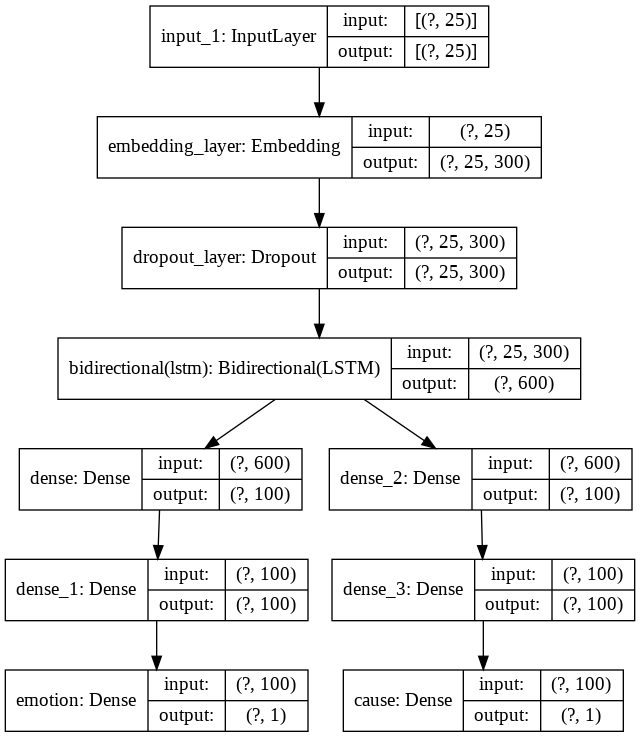

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/Information_Retrieval/IR_project/model_multitask_bilstm.png', show_shapes=True)
Image('/content/drive/My Drive/Information_Retrieval/IR_project/model_multitask_bilstm.png')

In [0]:
model.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics = {'emotion': 'accuracy','cause': 'accuracy'}, loss_weights = [1, 1])

In [530]:
import numpy as np

model.fit(X_train, [np.array(emotion_train_labels), np.array(cause_train_labels)],
          validation_data = (X_cv, [np.array(emotion_cv_labels), np.array(cause_cv_labels)]),
          #validation_split = 0.1,
          batch_size = 32,
          epochs = 1,
          verbose = True,
          shuffle = True)

37/37 [==============================] - 1s 37ms/step - loss: 0.0784 - emotion_loss: 0.0391 - cause_loss: 0.0393 - emotion_accuracy: 0.9923 - cause_accuracy: 0.9923 - val_loss: 0.2955 - val_emotion_loss: 0.1517 - val_cause_loss: 0.1438 - val_emotion_accuracy: 0.9559 - val_cause_accuracy: 0.9559


In [0]:
#model.save_weights("/content/drive/My Drive/Information_Retrieval/IR_project/emotion_cause_bilstm_classification_model.h5")

In [0]:
#model.load_weights("/content/drive/My Drive/Information_Retrieval/IR_project/emotion_cause_bilstm_classification_model.h5")

In [0]:
y_emotion_pred,y_cause_pred = model.predict(X_test)

In [0]:
y_emotion_pred = [ 1 if i > 0.5 else 0 for i in y_emotion_pred ]
y_cause_pred = [ 1 if i > 0.5 else 0 for i in y_cause_pred ]

In [533]:
from sklearn.metrics import  classification_report
import pandas as pd

class_report = classification_report(emotion_test_labels, y_emotion_pred, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.918605,0.981366,0.948949,0.949986,0.951022
recall,0.981366,0.918605,0.948949,0.949986,0.948949
f1-score,0.948949,0.948949,0.948949,0.948949,0.948949
support,161.000000,172.000000,0.948949,333.000000,333.000000


In [534]:
from sklearn.metrics import  classification_report
class_report = classification_report(cause_test_labels, y_cause_pred, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.981481,0.923977,0.951952,0.952729,0.953679
recall,0.924419,0.981366,0.951952,0.952893,0.951952
f1-score,0.952096,0.951807,0.951952,0.951952,0.951956
support,172.000000,161.000000,0.951952,333.000000,333.000000


### **EMOTION CAUSE PAIRS FILTERING MODEL USING BI-LSTM**

In [535]:
#From the emotion model and cause model we get the potential emotion cause pairs and then filter them
potential_emotion_cause_pairs_test = []
count_of_real_emotion_cause_pairs  = 0
for i in range(len(clauses_test)):
  for j in range(len(clauses_test)):
    if y_emotion_pred[i] == 1 and y_cause_pred[j] == 1 and (clauses_test[i],clauses_test[j]) in emotion_cause_pairs_test:
      potential_emotion_cause_pairs_test.append((clauses_test[i],clauses_test[j]))
      try:
        index = emotion_cause_pairs_test.index((clauses_test[i],clauses_test[j]))
        if emotion_cause_pairs_test_labels[index] == 1:
          count_of_real_emotion_cause_pairs+=1
      except:
        pass

print(len(potential_emotion_cause_pairs_test),emotion_cause_pairs_test_labels.count(1),count_of_real_emotion_cause_pairs)


153 173 153


In [0]:
filter_model_emotion_test,filter_model_cause_test = list(zip(*potential_emotion_cause_pairs_test))

filter_model_emotion_test = tokenizer.texts_to_sequences(filter_model_emotion_test)
filter_model_cause_test = tokenizer.texts_to_sequences(filter_model_cause_test)

filter_model_emotion_test = pad_sequences(filter_model_emotion_test, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
filter_model_cause_test   = pad_sequences(filter_model_cause_test, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

In [537]:
len(y_cause_pred),len(clauses_test),len(y_emotion_pred)

(333, 333, 333)

In [538]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dropout,LSTM,Bidirectional,Concatenate,Input,Dense,Flatten
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()
BILSTM_HIDDEN_UNITS = 100

emotion_clause_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
cause_clause_input   = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Using Word2Vec Model as embedding for emotion and cause clauses
emotion_embedding_layer =          Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='emotion_embedding_layer')

cause_embedding_layer =           Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='cause_embedding_layer')

emotion_embedded_clause_input = emotion_embedding_layer(emotion_clause_input)
cause_embedded_clause_input   = cause_embedding_layer(cause_clause_input)

# #Drop out for the embedding layer 
emotion_embedded_clause_dropped_input = Dropout(0.01)(emotion_embedded_clause_input)
cause_embedded_clause_dropped_input   = Dropout(0.01)(cause_embedded_clause_input)

emotion_clause_bilstm_output = Bidirectional(LSTM(BILSTM_HIDDEN_UNITS))(emotion_embedded_clause_dropped_input)
cause_clause_bilstm_output =   Bidirectional(LSTM(BILSTM_HIDDEN_UNITS))(cause_embedded_clause_dropped_input)

emotion_cause_combined_input = Concatenate(axis=1)([emotion_clause_bilstm_output,cause_clause_bilstm_output])
emotion_cause_combined_input = Flatten()(emotion_cause_combined_input)
output_1 = Dense(units = 100, activation='sigmoid')(emotion_cause_combined_input)
output_2 = Dense(units = 100, activation='sigmoid')(output_1)
final_output = Dense(units = 1, activation='sigmoid')(output_2)

model = Model(inputs=[emotion_clause_input,cause_clause_input], outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
emotion_embedding_layer (Embedd (None, 25, 300)      1149600     input_1[0][0]                    
__________________________________________________________________________________________________
cause_embedding_layer (Embeddin (None, 25, 300)      1149600     input_2[0][0]                    
______________________________________________________________________________________________

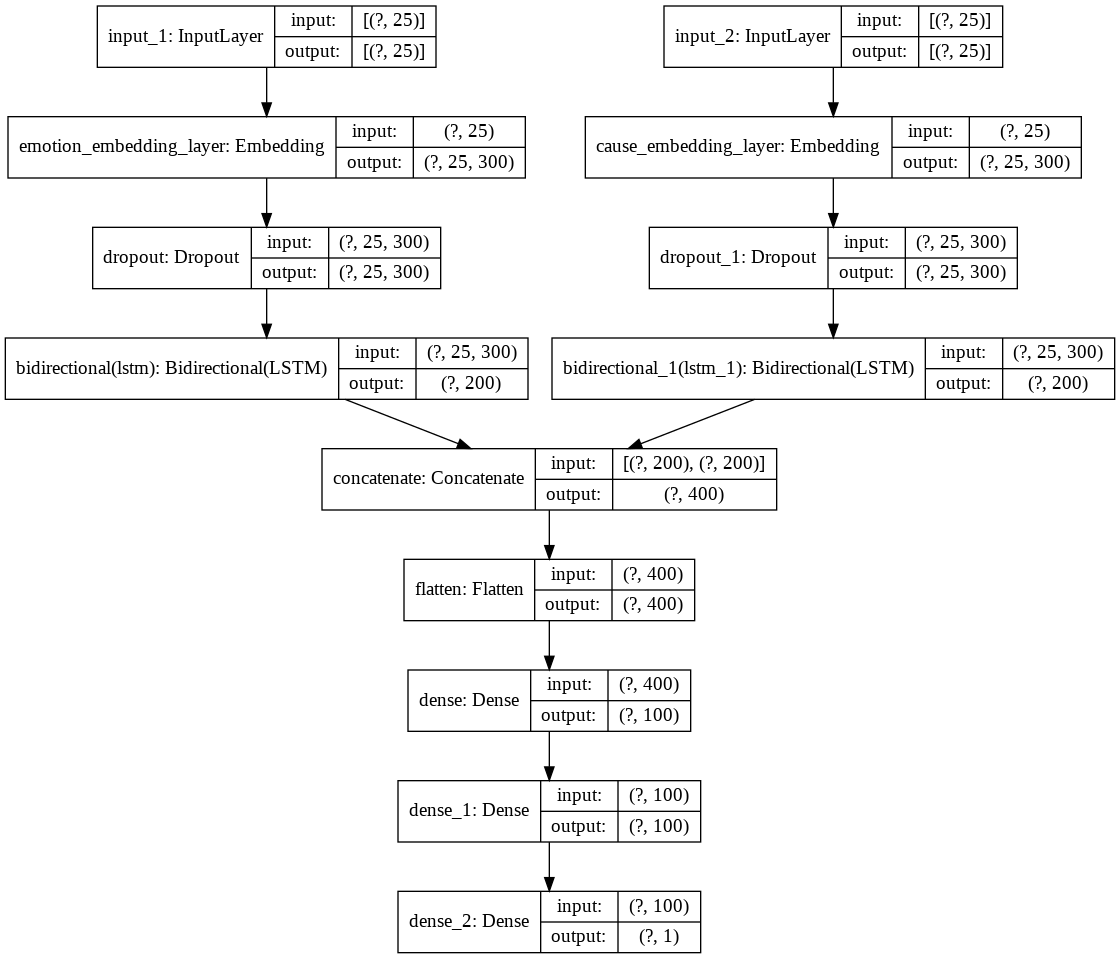

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/Information_Retrieval/IR_project/model_pair_filtering_bilstm.png', show_shapes=True)
Image('/content/drive/My Drive/Information_Retrieval/IR_project/model_pair_filtering_bilstm.png')

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics = ['accuracy'])

In [540]:
import numpy as np

model.fit([filter_model_emotion_train,filter_model_cause_train],np.array(emotion_cause_pairs_train_labels) ,
          validation_data = ([filter_model_emotion_cv,filter_model_cause_cv], np.array(emotion_cause_pairs_cv_labels)),
          #validation_split = 0.2,
          batch_size = 32,
          epochs = 4,
          verbose = True,
          shuffle = True)

Epoch 1/4
122/122 [==============================] - 6s 50ms/step - loss: 0.6284 - accuracy: 0.5924 - val_loss: 0.4381 - val_accuracy: 0.8410
Epoch 2/4
122/122 [==============================] - 5s 40ms/step - loss: 0.4378 - accuracy: 0.8404 - val_loss: 0.4338 - val_accuracy: 0.8410
Epoch 3/4
122/122 [==============================] - 5s 39ms/step - loss: 0.3885 - accuracy: 0.8404 - val_loss: 0.3211 - val_accuracy: 0.8410
Epoch 4/4
122/122 [==============================] - 5s 39ms/step - loss: 0.2353 - accuracy: 0.9272 - val_loss: 0.2477 - val_accuracy: 0.9194


In [0]:
#model.save_weights('/content/drive/My Drive/Information_Retrieval/IR_project/emotion_cause_filtering_bilstm.h5')

In [0]:
#model.load_weights('/content/drive/My Drive/Information_Retrieval/IR_project/emotion_cause_filtering_bilstm.h5')

In [0]:
emotion_cause_pairs_pred_labels = model.predict([filter_model_emotion_test,filter_model_cause_test])

In [0]:
emotion_cause_pairs_pred_labels = [0 if i[0] < 0.5 else 1 for i in emotion_cause_pairs_pred_labels]

In [543]:
proposed_pairs = list(emotion_cause_pairs_pred_labels).count(1)
annotated_pairs = emotion_cause_pairs_test_labels.count(1)
correct_pairs = list(emotion_cause_pairs_pred_labels).count(1)

precision = correct_pairs/proposed_pairs
recall = correct_pairs/annotated_pairs

f1_score = 2*precision*recall/(precision+recall)

print("Precision: {} Recall: {} F1 score: {}".format(precision,recall,f1_score))

Precision: 1.0 Recall: 0.6184971098265896 F1 score: 0.7642857142857142


### **EMOTION AND CAUSE CLASSIFICATION MODEL USING BI-LSTM ATTENTION**

In [544]:
import tensorflow as tf
from keras import initializers

tf.keras.backend.clear_session()

BILSTM_HIDDEN_UNITS = 300

clause_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Using Word2Vec Model as pretrained embedding 
embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='embedding_layer')

embedded_clause_input = embedding_layer(clause_input)
#Drop out for the embedding layer 
embedded_clause_dropped_input = tf.keras.layers.Dropout(0.8,name='dropout_layer')(embedded_clause_input)
clause_bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BILSTM_HIDDEN_UNITS,return_sequences=True
                                                    ))(embedded_clause_dropped_input)

clause_attention_output = tf.keras.layers.Attention()([clause_bilstm_output, clause_bilstm_output])

# emotion_clause_bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BILSTM_HIDDEN_UNITS
#                                                     ))(clause_attention_output)

# cause_clause_bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BILSTM_HIDDEN_UNITS
#                                                     ))(clause_attention_output)                                                  

output_emotion_1 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(clause_attention_output)
output_emotion_2 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(output_emotion_1)
output_emotion = tf.keras.layers.Dense(units = 1, activation='sigmoid', name = 'emotion')(output_emotion_2)

output_cause_1 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(clause_attention_output)
output_cause_2 = tf.keras.layers.Dense(units = 100, activation='sigmoid')(output_cause_1)
output_cause = tf.keras.layers.Dense(units = 1,activation='sigmoid', name = 'cause')(output_cause_2) 

model = tf.keras.models.Model(inputs=clause_input, outputs=[output_emotion, output_cause])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 25, 300)      1149600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_layer (Dropout)         (None, 25, 300)      0           embedding_layer[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 25, 600)      1442400     dropout_layer[0][0]              
______________________________________________________________________________________________

In [0]:
model.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics = {'emotion': 'accuracy','cause': 'accuracy'}, loss_weights = [1, 1])

In [582]:
import numpy as np

history = model.fit(X_train, [np.array(emotion_train_labels), np.array(cause_train_labels)],
            validation_data = (X_cv, [np.array(emotion_cv_labels), np.array(cause_cv_labels)]),
            #validation_split = 0.1,
            batch_size = 32,
            epochs = 1,
            verbose = True,
            shuffle = True)

37/37 [==============================] - 2s 43ms/step - loss: 0.1329 - emotion_loss: 0.0660 - cause_loss: 0.0669 - emotion_accuracy: 0.9746 - cause_accuracy: 0.9745 - val_loss: 0.3772 - val_emotion_loss: 0.1944 - val_cause_loss: 0.1828 - val_emotion_accuracy: 0.9406 - val_cause_accuracy: 0.9412


In [198]:
#model.save_weights('/content/drive/My Drive/Information_Retrieval/IR_project/bilsitm_attention_bilstm_classification_model.h5')
#0.97
print('Done')

Done


In [0]:
#model.load_weights('/content/drive/My Drive/Information_Retrieval/IR_project/bilsitm_attention_bilstm_classification_model.h5')

In [0]:
y_emotion_pred,y_cause_pred = model.predict(X_test)

In [0]:
y_emotion_pred = [ 1 if i[0] > 0.5 else 0 for i in y_emotion_pred ]
y_cause_pred = [ 1 if i[0] > 0.5 else 0 for i in y_cause_pred ]

In [585]:
from sklearn.metrics import  classification_report
import pandas as pd

class_report = classification_report(emotion_test_labels, y_emotion_pred, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.945783,0.976048,0.960961,0.960916,0.961415
recall,0.975155,0.947674,0.960961,0.961415,0.960961
f1-score,0.960245,0.961652,0.960961,0.960948,0.960972
support,161.000000,172.000000,0.960961,333.000000,333.000000


In [586]:
from sklearn.metrics import  classification_report
class_report = classification_report(cause_test_labels, y_cause_pred, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.981928,0.946108,0.963964,0.964018,0.964609
recall,0.947674,0.981366,0.963964,0.964520,0.963964
f1-score,0.964497,0.963415,0.963964,0.963956,0.963974
support,172.000000,161.000000,0.963964,333.000000,333.000000


### **EMOTION CAUSE PAIRS FILTERING MODEL USING BI-LSTM ATTENTION**

In [587]:
#From the emotion model and cause model we get the potential emotion cause pairs and then filter them
potential_emotion_cause_pairs_test = []
count_of_real_emotion_cause_pairs  = 0
for i in range(len(clauses_test)):
  for j in range(len(clauses_test)):
    if y_emotion_pred[i] == 1 and y_cause_pred[j] == 1 and (clauses_test[i],clauses_test[j]) in emotion_cause_pairs_test:
      potential_emotion_cause_pairs_test.append((clauses_test[i],clauses_test[j]))
      try:
        index = emotion_cause_pairs_test.index((clauses_test[i],clauses_test[j]))
        if emotion_cause_pairs_test_labels[index] == 1:
          count_of_real_emotion_cause_pairs+=1
      except:
        pass

print(len(potential_emotion_cause_pairs_test),emotion_cause_pairs_test_labels.count(1),count_of_real_emotion_cause_pairs)


156 173 156


In [0]:
filter_model_emotion_test,filter_model_cause_test = list(zip(*potential_emotion_cause_pairs_test))

filter_model_emotion_test = tokenizer.texts_to_sequences(filter_model_emotion_test)
filter_model_cause_test = tokenizer.texts_to_sequences(filter_model_cause_test)

filter_model_emotion_test = pad_sequences(filter_model_emotion_test, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
filter_model_cause_test   = pad_sequences(filter_model_cause_test, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

In [589]:
len(y_emotion_pred),len(clauses_test),len(y_cause_pred)

(333, 333, 333)

In [590]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dropout,LSTM,Bidirectional,Concatenate,Input,Dense,Flatten,Attention,AdditiveAttention
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()
BILSTM_HIDDEN_UNITS = 100

emotion_clause_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
cause_clause_input   = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Using Word2Vec Model as embedding for emotion and cause clauses
emotion_embedding_layer =          Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='emotion_embedding_layer')

cause_embedding_layer =           Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True,
                                            name='cause_embedding_layer')

emotion_embedded_clause_input = emotion_embedding_layer(emotion_clause_input)
cause_embedded_clause_input   = cause_embedding_layer(cause_clause_input)

# #Drop out for the embedding layer 
emotion_embedded_clause_dropped_input = Dropout(0.01)(emotion_embedded_clause_input)
cause_embedded_clause_dropped_input   = Dropout(0.01)(cause_embedded_clause_input)

emotion_clause_bilstm_output = Bidirectional(LSTM(BILSTM_HIDDEN_UNITS,return_sequences = True))(emotion_embedded_clause_dropped_input)
cause_clause_bilstm_output =   Bidirectional(LSTM(BILSTM_HIDDEN_UNITS,return_sequences = True))(cause_embedded_clause_dropped_input)

emotion_clause_attention_output = Attention()([emotion_clause_bilstm_output,emotion_clause_bilstm_output])
cause_clause_attention_output = Attention()([cause_clause_bilstm_output,cause_clause_bilstm_output])

emotion_cause_combined_input = Concatenate(axis=1)([emotion_clause_attention_output,cause_clause_attention_output])
emotion_cause_combined_input = Flatten()(emotion_cause_combined_input)

output_1 = Dense(units = 500, activation='sigmoid')(emotion_cause_combined_input)
output_2 = Dense(units = 500, activation='sigmoid')(output_1)
final_output = Dense(units = 1, activation='sigmoid')(output_2)

model = Model(inputs=[emotion_clause_input,cause_clause_input], outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
emotion_embedding_layer (Embedd (None, 25, 300)      1149600     input_1[0][0]                    
__________________________________________________________________________________________________
cause_embedding_layer (Embeddin (None, 25, 300)      1149600     input_2[0][0]                    
______________________________________________________________________________________________

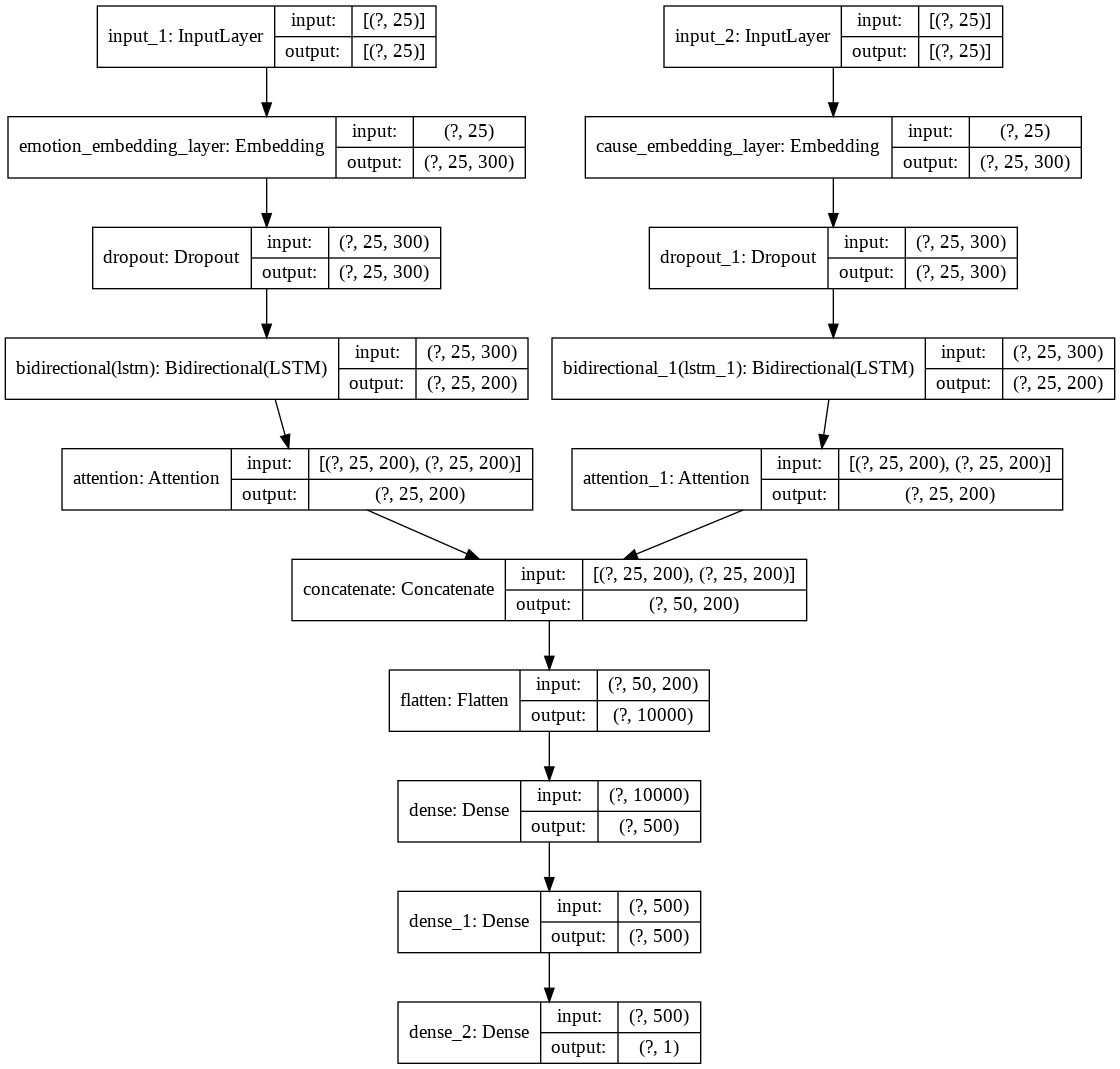

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/Information_Retrieval/IR_project/model_pair_filtering_bilstm_attention.png', show_shapes=True)
Image('/content/drive/My Drive/Information_Retrieval/IR_project/model_pair_filtering_bilstm_attention.png')

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics = ['accuracy'])

In [632]:
import numpy as np
from sklearn.model_selection import train_test_split

model.fit([filter_model_emotion_train,filter_model_cause_train],np.array(emotion_cause_pairs_train_labels) ,
          validation_data = ([filter_model_emotion_cv,filter_model_cause_cv], np.array(emotion_cause_pairs_cv_labels)),
          #validation_split = 0.1,
          batch_size = 32,
          epochs = 1,
          verbose = True,
          shuffle = True)

122/122 [==============================] - 6s 45ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.4972 - val_accuracy: 0.9032


In [0]:
#model.save_weights('/content/drive/My Drive/Information_Retrieval/IR_project/bilsitm_attention_filtering_model.h5')

In [0]:
#model.load_weights('/content/drive/My Drive/Information_Retrieval/IR_project/bilsitm_attention_filtering_model.h5')

In [0]:
emotion_cause_pairs_pred_labels = model.predict([filter_model_emotion_test,filter_model_cause_test])

In [0]:
emotion_cause_pairs_pred_labels = [0 if i[0] < 0.5 else 1 for i in emotion_cause_pairs_pred_labels]

In [635]:
proposed_pairs = list(emotion_cause_pairs_pred_labels).count(1)
annotated_pairs = emotion_cause_pairs_test_labels.count(1)
correct_pairs = list(emotion_cause_pairs_pred_labels).count(1)

precision = correct_pairs/proposed_pairs
recall = correct_pairs/annotated_pairs

f1_score = 2*precision*recall/(precision+recall)

print("Precision: {} Recall: {} F1 score: {}".format(precision,recall,f1_score))

Precision: 1.0 Recall: 0.5953757225433526 F1 score: 0.7463768115942029


### **EMOTION and CAUSE CLASSIFICATION USING BERT**

In [0]:
!pip3 install ktrain

     |████████████████████████████████| 25.2MB 128kB/s 
     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 983kB 40.6MB/s 
     |████████████████████████████████| 245kB 47.2MB/s 
     |████████████████████████████████| 573kB 41.1MB/s 
     |████████████████████████████████| 471kB 46.9MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
     |████████████████████████████████| 3.9MB 50.4MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
     |████████████████████████████████| 1.0MB 41.9MB/s 
     |████████████████████████████████| 3.7MB 38.8MB/s 
  Created wheel for ktrain: filename=ktrain-0.14.2-cp36-none-any.whl size=25245177 sha256=3a14e621cc5c1b617e4aec22d704058845cefbc4ce85862673be661a6dbcc6d3
  Stored in directory: /root/.cache/pip/wheels/d2/52/11/747feea8ec83ff98a49d81dd1115a67ceb7b4a4ed0f8a37efe
  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=b2197755fd50447a589a27d8c9c

In [0]:
import ktrain
from ktrain import text

In [0]:
import pandas as pd

emotion_train_data = []
cause_train_data = []
for i in range(len(clauses_train)):
  emotion_train_data.append([" ".join(clauses_train[i]),emotion_train_labels[i]])
  cause_train_data.append([" ".join(clauses_train[i]),cause_train_labels[i]])

emotion_test_data = []
cause_test_data = []
for i in range(len(clauses_test)):
  emotion_test_data.append([" ".join(clauses_test[i]),emotion_test_labels[i]])
  cause_test_data.append([" ".join(clauses_test[i]),cause_test_labels[i]])

emotion_train_dataframe = pd.DataFrame(data=emotion_train_data,columns = ['Text','Label'])
cause_train_dataframe = pd.DataFrame(data=cause_train_data,columns = ['Text','Label'])

emotion_test_dataframe = pd.DataFrame(data=emotion_test_data,columns = ['Text','Label'])
cause_test_dataframe = pd.DataFrame(data=cause_test_data,columns = ['Text','Label'])

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=emotion_train_dataframe,text_column='Text',
                                                                   label_columns=['Label'],maxlen = 512,
                                                                   #val_df = emotion_test_dataframe,
                                                                   preprocess_mode='bert',
                                                                   random_state = 0,max_features = 100000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
bert_emotion_model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(bert_emotion_model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

Is Multi-Label? False
maxlen is 512
done.


In [0]:
learner.fit_onecycle(2e-5, 2,checkpoint_folder='/content/drive/My Drive/Information_Retrieval/IR_project/')



begin training using onecycle policy with max lr of 2e-05...
Train on 1168 samples, validate on 130 samples
Epoch 1/2
1168/1168 [==============================] - 142s 121ms/sample - loss: 0.3474 - accuracy: 0.8493 - val_loss: 0.0742 - val_accuracy: 0.9692
Epoch 2/2
1168/1168 [==============================] - 118s 101ms/sample - loss: 0.0698 - accuracy: 0.9777 - val_loss: 0.0530 - val_accuracy: 0.9769


In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)
y_pred = predictor.predict(emotion_test_dataframe['Text'].values)
emotion_pred_label = [ 0 if i == "0" else 1 for i in y_pred ]

In [0]:
from sklearn.metrics import  classification_report
class_report = classification_report(emotion_test_labels, emotion_pred_label, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.969325,0.97076,0.97006,0.970043,0.97006
recall,0.969325,0.97076,0.97006,0.970043,0.97006
f1-score,0.969325,0.97076,0.97006,0.970043,0.97006
support,163.000000,171.00000,0.97006,334.000000,334.00000


In [0]:
import pickle

with open('/content/drive/My Drive/Information_Retrieval/IR_project/emotion_bert_pred_label.pickle','wb') as file:
  pickle.dump(emotion_pred_label,file)

In [0]:
import pickle
with open('/content/drive/My Drive/Information_Retrieval/IR_project/emotion_bert_pred_label.pickle','rb') as file:
  emotion_pred_label = pickle.load(file)

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=cause_train_dataframe,text_column='Text',
                                                                   label_columns=['Label'],maxlen = 512,
                                                                   #val_df = cause_test_dataframe, 
                                                                   preprocess_mode='bert',
                                                                   random_state = 0,max_features = 100000)

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
bert_model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(bert_model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

Is Multi-Label? False
maxlen is 512
done.


In [0]:
import tensorflow as tf

tf.keras.backend.clear_session()
learner.fit_onecycle(2e-5, 2,checkpoint_folder='/content/drive/My Drive/Information_Retrieval/IR_project')



begin training using onecycle policy with max lr of 2e-05...
Train on 1168 samples, validate on 130 samples
Epoch 1/2
1168/1168 [==============================] - 140s 120ms/sample - loss: 0.2847 - accuracy: 0.8913 - val_loss: 0.0735 - val_accuracy: 0.9769
Epoch 2/2
1168/1168 [==============================] - 116s 100ms/sample - loss: 0.0542 - accuracy: 0.9837 - val_loss: 0.0260 - val_accuracy: 0.9923


In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)
y_pred = predictor.predict(cause_test_dataframe['Text'].values)
cause_pred_label = [ 0 if i == "0" else 1 for i in y_pred ]

In [0]:
from sklearn.metrics import  classification_report
class_report = classification_report(cause_test_labels, cause_pred_label, target_names=[0,1], output_dict=True)
report = pd.DataFrame(data = class_report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.976879,0.987578,0.982036,0.982228,0.982100
recall,0.988304,0.975460,0.982036,0.981882,0.982036
f1-score,0.982558,0.981481,0.982036,0.982020,0.982033
support,171.000000,163.000000,0.982036,334.000000,334.000000


In [0]:
import pickle

with open('/content/drive/My Drive/Information_Retrieval/IR_project/cause_bert_pred_label.pickle','wb') as file:
  pickle.dump(cause_pred_label,file)

In [0]:
import pickle

with open('/content/drive/My Drive/Information_Retrieval/IR_project/cause_bert_pred_label.pickle','rb') as f:
  cause_pred_label = pickle.load(f)

# **ANALYSIS OF RESULTS**

### **TFIDF REPRESENTATION**

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

clauses_text = [" ".join(l) for l in document_clauses]
print(len(clauses_text))
tfidfVectorizer = TfidfVectorizer(min_df = 0)
clauses_vectors = tfidfVectorizer.fit_transform(clauses_text)
clauses_vectors_standardised = StandardScaler().fit_transform(clauses_vectors.toarray())

2389


In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

xtsne=TSNE(perplexity=10)
results=xtsne.fit_transform(clauses_vectors_standardised)
results_2 = results[:,[0,1]]


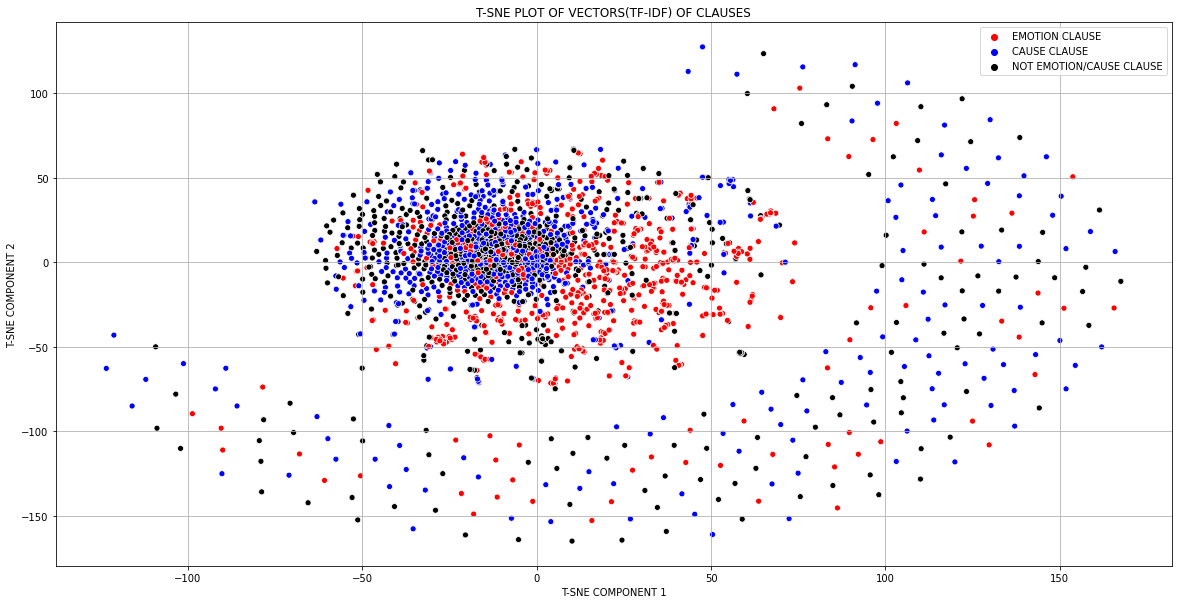

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20,10))
plt.grid()
labels = []
for i in range(len(emotion_labels)):
  if emotion_labels[i] == 1:
    labels.append('EMOTION CLAUSE')
  elif cause_labels[i] == 1:
    labels.append("CAUSE CLAUSE")
  else:
    labels.append("NOT EMOTION/CAUSE CLAUSE")

sns.scatterplot(x="T-SNE COMPONENT 1", y="T-SNE COMPONENT 2", data=pd.DataFrame(data = results_2,columns = ['T-SNE COMPONENT 1','T-SNE COMPONENT 2']),hue = labels,palette=['red','blue','black'])
plt.title('T-SNE PLOT OF VECTORS(TF-IDF) OF CLAUSES')
plt.savefig('/content/drive/My Drive/Information_Retrieval/IR_project/tsne-clause-vectors-tfidf.png')
plt.show()


#### **EMOTION CAUSE PAIR FILTERING** 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

emotion_cause_pair_text = [" ".join(e+c) for e,c in emotion_cause_pairs]

tfidfVectorizer = TfidfVectorizer(min_df = 0)
emotion_cause_pair_vectors = tfidfVectorizer.fit_transform(emotion_cause_pair_text)

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

emotion_cause_pair_vectors_standardised = StandardScaler().fit_transform(emotion_cause_pair_vectors.toarray())
xtsne=TSNE(perplexity=10)
results=xtsne.fit_transform(emotion_cause_pair_vectors_standardised)
results_2 = results[:,[0,1]]

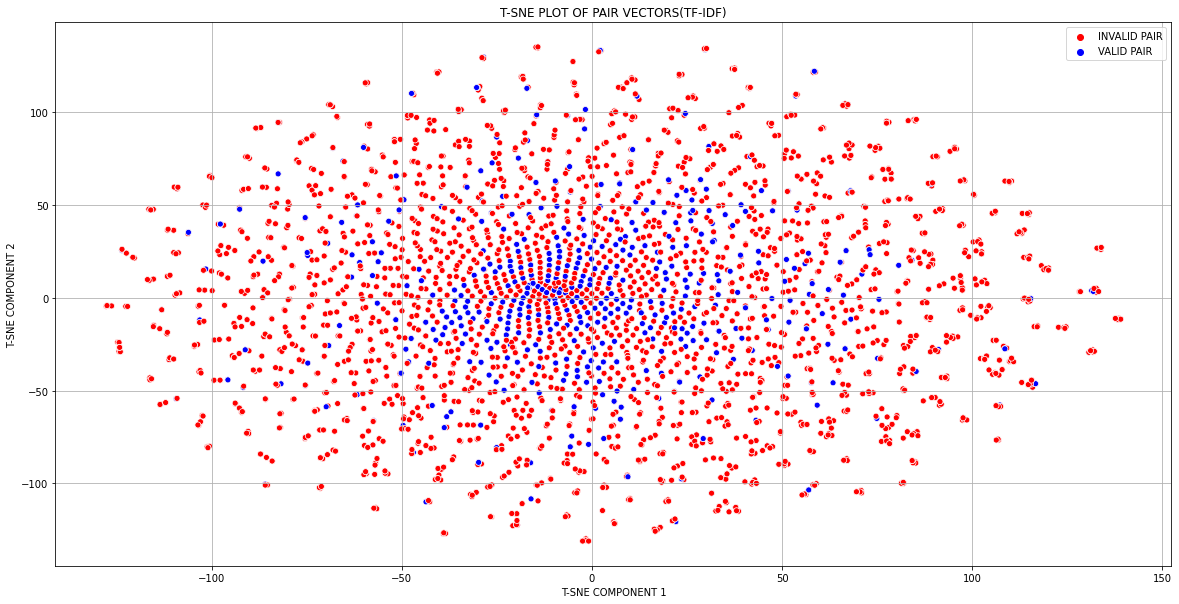

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20,10))
plt.grid()
labels = [ "INVALID PAIR" if l == "None" else "VALID PAIR" for l in emotion_cause_pairs_labels]
sns.scatterplot(x="T-SNE COMPONENT 1", y="T-SNE COMPONENT 2", data=pd.DataFrame(data = results_2,columns = ['T-SNE COMPONENT 1','T-SNE COMPONENT 2']),hue = labels,palette=['red','blue'])
plt.title('T-SNE PLOT OF PAIR VECTORS(TF-IDF)')
plt.savefig('/content/drive/My Drive/Information_Retrieval/IR_project/tsne-pair-vectors-tfidf.png')
plt.show()


### **WORD2VEC REPRESENTATION**

#### **Emotion and Cause classification**

In [0]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus(object):
    def __iter__(self): 
        for line in documents:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [0]:
import gensim.models
#skipgram model
sentences = MyCorpus()
skipGramModel = gensim.models.Word2Vec(sentences=sentences,sg = 1,workers=4,iter = 70,batch_words=1,min_count=1)

In [0]:
import numpy as np
from sklearn.preprocessing import StandardScaler

#document_clauses, emotion_labels, cause_labels
clauses_vectors = np.zeros((len(document_clauses),100))
for i in range(len(document_clauses)):
  for j in range(len(document_clauses[i])):
    try:
        clauses_vectors[i]+=skipGramModel.wv.get_vector(document_clauses[i][j])
    except:
        pass

clauses_vectors_standardised = StandardScaler().fit_transform(clauses_vectors)

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

xtsne=TSNE(perplexity=10)
results=xtsne.fit_transform(clauses_vectors_standardised)
results_2 = results[:,[0,1]]


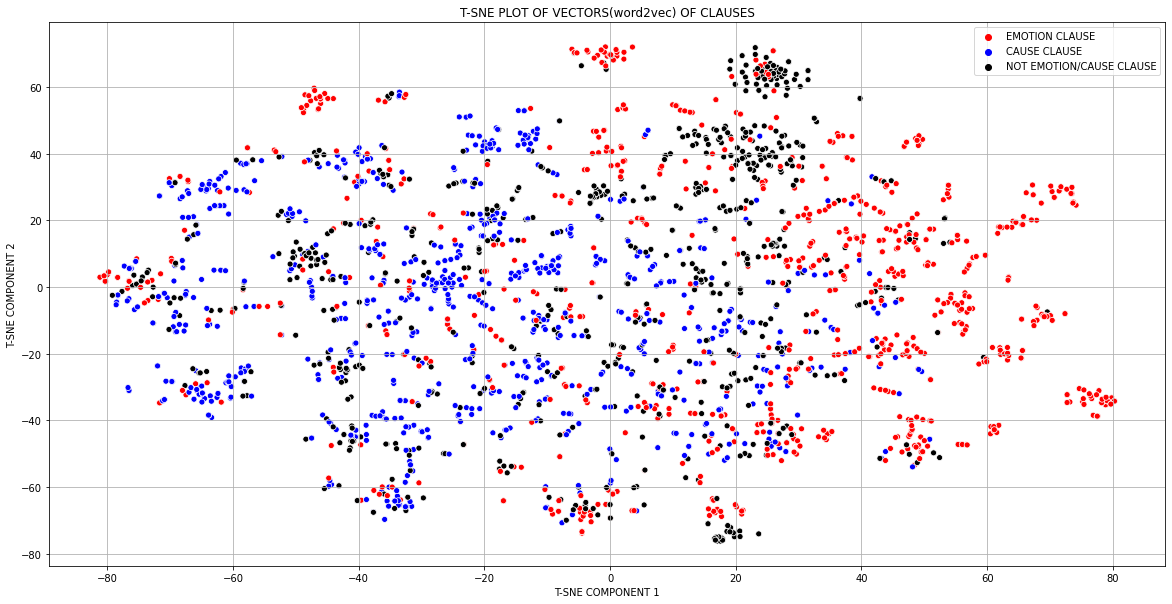

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20,10))
plt.grid()
labels = []
for i in range(len(emotion_labels)):
  if emotion_labels[i] == 1:
    labels.append('EMOTION CLAUSE')
  elif cause_labels[i] == 1:
    labels.append("CAUSE CLAUSE")
  else:
    labels.append("NOT EMOTION/CAUSE CLAUSE")

sns.scatterplot(x="T-SNE COMPONENT 1", y="T-SNE COMPONENT 2", data=pd.DataFrame(data = results_2,columns = ['T-SNE COMPONENT 1','T-SNE COMPONENT 2']),hue = labels,palette=['red','blue','black'])
plt.title('T-SNE PLOT OF VECTORS(word2vec) OF CLAUSES')
plt.savefig('/content/drive/My Drive/Information_Retrieval/IR_project/tsne-clause-vectors-word2vec.png')
plt.show()


#### **Emotion Cause Pair filtering**

In [0]:
import numpy as np
emotion_cause_pair_vectors = []

for e,c in emotion_cause_pairs:
  emotion_vector = np.zeros(100)
  for j in range(len(e)):
    try:
        emotion_vector+=skipGramModel.wv.get_vector(e[j])
    except:
        pass

  cause_vector = np.zeros(100)
  for j in range(len(c)):
    try:
        cause_vector+=skipGramModel.wv.get_vector(c[j])
    except:
        pass

  emotion_cause_pair_vectors.append(np.concatenate((emotion_vector,cause_vector)))

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

emotion_cause_pair_vectors_standardised = StandardScaler().fit_transform(emotion_cause_pair_vectors)
xtsne=TSNE(perplexity=10)
results=xtsne.fit_transform(emotion_cause_pair_vectors_standardised)
results_2 = results[:,[0,1]]

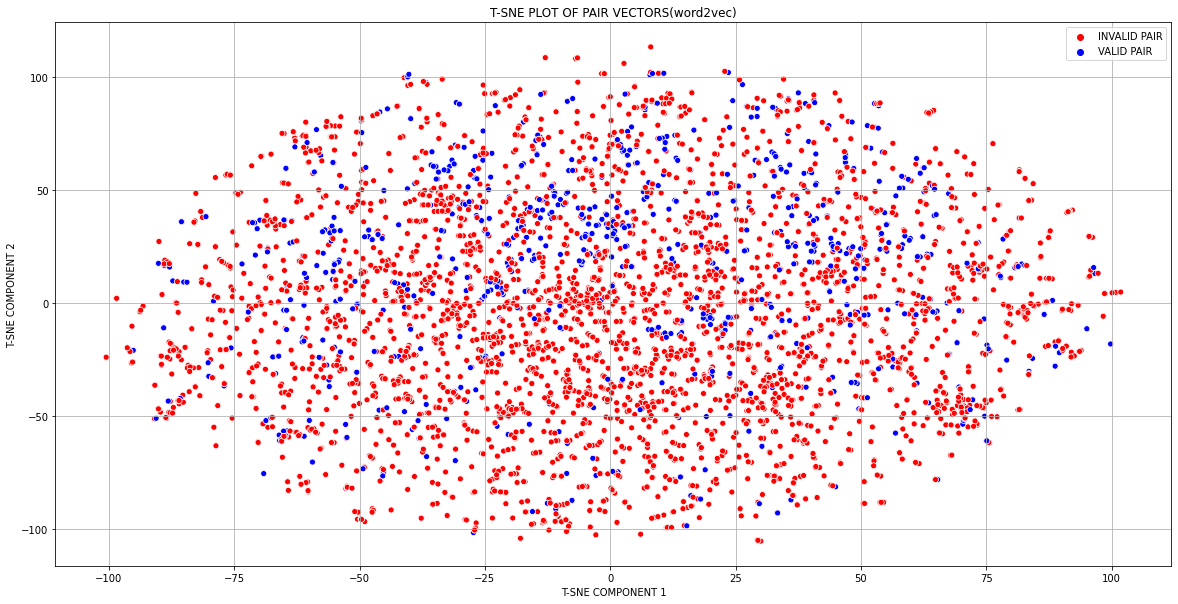

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20,10))
plt.grid()
labels = [ "INVALID PAIR" if l == "None" else "VALID PAIR" for l in emotion_cause_pairs_labels]
sns.scatterplot(x="T-SNE COMPONENT 1", y="T-SNE COMPONENT 2", data=pd.DataFrame(data = results_2,columns = ['T-SNE COMPONENT 1','T-SNE COMPONENT 2']),hue = labels,palette=['red','blue'])
plt.title('T-SNE PLOT OF PAIR VECTORS(word2vec)')
plt.savefig('/content/drive/My Drive/Information_Retrieval/IR_project/tsne-pair-vectors-word2vec.png')
plt.show()


### **SIGNIFICANCE TESTING**
5 different F1 scores were obtained by randomising the train test split with following seeds: 10,15,27,33,56

In [2]:
#Comparing TF-IDF+ SVM and Bi-LSTM for emotion classification
from scipy.stats import ks_2samp

tfidf_svm_f1_emotion_classification_scores = [0.955077,0.929204,0.923685,0.934331,0.927901]
bilstm_f1_emotion_classification_scores = [0.967047,0.964578,0.951223,0.946266,0.948949]

value, pvalue = ks_2samp(tfidf_svm_f1_emotion_classification_scores, bilstm_f1_emotion_classification_scores)
print(value, pvalue)
if pvalue > 0.1:
	print('Samples are likely drawn from the same distributions (10% significance level)')
else:
	print('Samples are likely drawn from different distributions (10% significance level)')

0.8 0.07936507936507936
Samples are likely drawn from different distributions (10% significance level)


In [3]:
#Comparing word2vec+SVM and Bi-LSTM+Attention for emotion cause pair filtering

word2vec_svm_f1_piar_scores = [0.7553,0.7137,0.7232,0.7463,0.7089]
bilstm_attention_f1_pair_scores = [0.7986,0.7944,0.8109,0.7816,0.8389]

value, pvalue = ks_2samp(word2vec_svm_f1_piar_scores, bilstm_attention_f1_pair_scores)
print(value, pvalue)
if pvalue > 0.05:
	print('Samples are likely drawn from the same distributions (5% significance level)')
else:
	print('Samples are likely drawn from different distributions (5% significance level)')

1.0 0.007936507936507936
Samples are likely drawn from different distributions (5% significance level)


In [4]:
#Comparing Bi-LSTM and Bi-LSTM+Attention for emotion cause pair filtering
bilstm_f1_piar_scores = [0.7509,0.7553,0.7509,0.7509,0.7642]
bilstm_attention_f1_pair_scores = [0.7986,0.7944,0.8109,0.7816,0.8389]

value, pvalue = ks_2samp(word2vec_svm_f1_piar_scores, bilstm_attention_f1_pair_scores)
print(value, pvalue)
if pvalue > 0.05:
	print('Samples are likely drawn from the same distributions (5% significance level)')
else:
	print('Samples are likely drawn from different distributions (5% significance level)')

1.0 0.007936507936507936
Samples are likely drawn from different distributions (5% significance level)
